# Alternating Direction Method of Multipliers

Although gradient descent is a reliable algorithm that is guaranteed to converge, it is still slow. If we want to process larger sets of data (e.g. 3D imaging), have a live feed of DiffuserCam, or just want to process images more quickly, we need to tailor the algorithm more closely to the optical system involved. While this introduces more tuning parameters ("knobs" to turn), speed of reconstruction can be drastically improved. Here we present (without proof) the result of using <i>alternating direction method of multipiers (ADMM)</i> to  reconstruct the image.

For background on ADMM, please refer to sections 2 and 3 of: http://stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf. To understand this document, background knowledge from Chapters 5 (Duality) and 9 (Unconstrained minimization) from https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf may be necessary.

For a detailed derivation of the update steps as they apply to our system, refer to the companion documents to this notebook (specific sections will be referenced).

#### Generic setup code (load psf, etc.)

In [1]:
%matplotlib inline
import numpy as np
import numpy.fft as fft
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import global_vars as gv

Using GPU


The code takes in two grayscale images: a point spread function (PSF) $\texttt{psfname}$ and a sensor measurement $\texttt{imgname}$. The images can be downsampled by a factor $f$, which is a power of $\frac{1}{2}$

In [2]:
"""Stuff that is normally in the config file"""
psfname = gv.rngcam_dir + "psf/psf_og.jpg"
imgname = gv.save_diff_filepath

# Downsampling factor (used to shrink images)
f = 1

# Hyper-parameters in the ADMM implementation (like step size in GD)
mu1 = 1e-6
mu2 = 1e-5
mu3 = 4e-5
tau = 0.0001

# Number of iterations
iters = 5

In [3]:
def loaddata(show_im=True):
    psf = Image.open(psfname)
    psf = np.array(psf, dtype='float32')
    data = Image.open(imgname)
    data = np.array(data, dtype='float32')
    
    print("PSF Shape: ", psf.shape)
    print("Image Shape: ", data.shape)
    
    # """In the picamera, there is a non-trivial background 
    # (even in the dark) that must be subtracted"""
    # bg = np.mean(psf[5:15,5:15]) 
    # psf -= bg
    # data -= bg
    
    """Resize to a more manageable size to do reconstruction on. 
    Because resizing is downsampling, it is subject to aliasing 
    (artifacts produced by the periodic nature of sampling). Demosaicing is an attempt
    to account for/reduce the aliasing caused. In this application, we do the simplest
    possible demosaicing algorithm: smoothing/blurring the image with a box filter"""
    
    # def resize(img, factor):
    #     num = int(-np.log2(factor))
    #     for i in range(num):
    #         img = 0.25*(img[::2,::2,...]+img[1::2,::2,...]+img[::2,1::2,...]+img[1::2,1::2,...])
    #     return img    
    
    # psf = resize(psf, f)
    # data = resize(data, f)
    
    
    """Now we normalize the images so they have the same total power. Technically not a
    necessary step, but the optimal hyperparameters are a function of the total power in 
    the PSF (among other things), so it makes sense to standardize it"""
    
    # psf /= np.linalg.norm(psf.ravel())
    # data /= np.linalg.norm(data.ravel())

    psf /= 255.0
    data /= 255.0
    
    if show_im:
        fig1 = plt.figure()
        plt.imshow(psf, cmap='gray')
        plt.title('PSF')
        display.display(fig1)
        fig2 = plt.figure()
        plt.imshow(data)
        plt.title('Raw data')
        display.display(fig2)
        
    return psf, data
    

PSF Shape:  (228, 342, 3)
Image Shape:  (228, 342, 3)


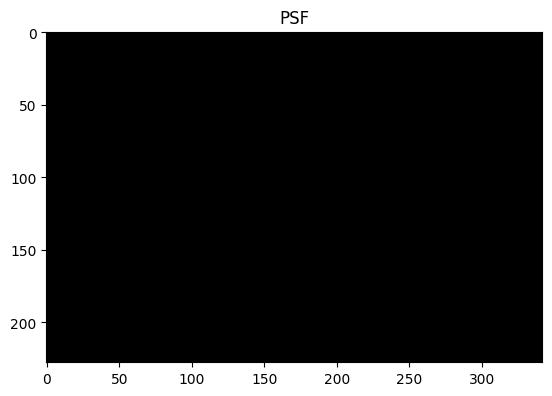

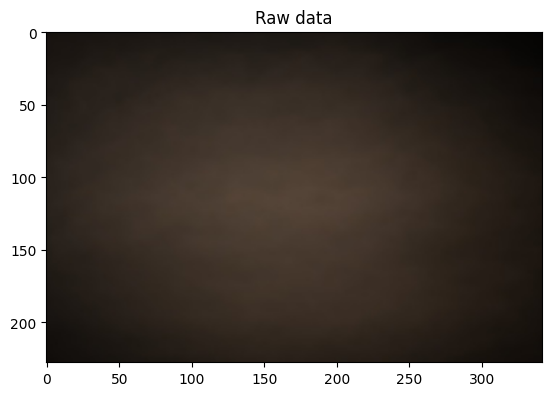

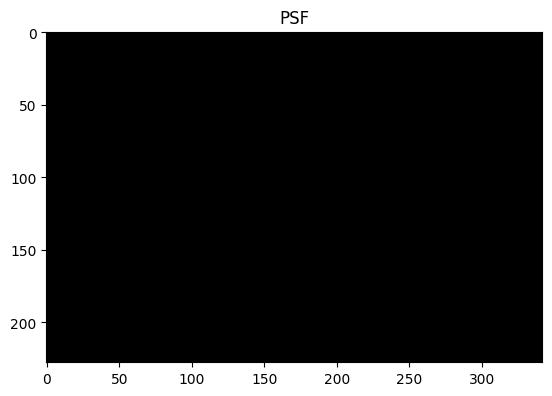

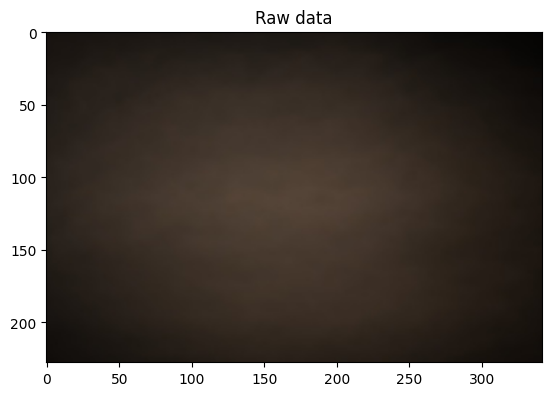

In [4]:
"""The "uncropped" size of the image. As with the gradient descent, we pad the images 
so that convolution is linear instead of circular"""
psf, data = loaddata(True)
sensor_size = np.array(psf.shape)
full_size = 2*sensor_size

$\newcommand\sensorco{\mathbf{x}} % vector containing (x,y) sensor coordinates$
$\newcommand\objectco{\bm \xi} % vector containing (x,y) object coordinates$
$\newcommand\measurementvec{\mathbf{b}}$
$\newcommand\measurementmtx{\mathbf{M}}$
$\newcommand\full{\mathbf{A}}$
$\newcommand\imagevec{\mathbf{v}}$
$\newcommand{\crop}{\mathbf{C}}$
$\newcommand{\rhcomment}[1]{{\bf{{\blue{{RH --- #1}}}}}}$
$\newcommand{\argmin}{\text{argmin }}$

Recall the objective function:

\begin{equation} \begin{aligned} \hat{\imagevec} = \underset{w\geq 0,u,x}{\argmin}&\frac{1}{2}\|\measurementvec - \crop x\|_2^2  + \tau \|u\|_1\\ \mbox{s.t. } &x = \measurementmtx \imagevec, w = \imagevec\text{,} \end{aligned} \end{equation}

For reference, the corresponding ADMM update steps derived in the companion document are:
\begin{align*}
    u_{k+1} &\leftarrow \mathcal{T}_{\frac{\tau}{\mu_2}} \left(\Psi \imagevec_k + \frac{\eta_k}{\mu_2}\right) \\
    x_{k+1} &\leftarrow \left(\crop^H \crop + \mu_1 I\right)^{-1}
\left(\xi_k + \mu_1 \mathbf{M}\imagevec_k + \crop^H \measurementvec\right) \\
w_{k+1} &\leftarrow \max(\rho_k/\mu_3 +\imagevec_k, 0) \\
\imagevec_{k+1} &\leftarrow (\mu_1 \mathbf{M}^H \mathbf{M} + \mu_2 \Psi^H \Psi + \mu_3 I)^{-1} r_k, \\
    \xi_{k+1} & \leftarrow \xi_k + \mu_1(\measurementmtx \imagevec_k - x_{k+1}) \\
    \eta_{k+1} & \leftarrow \eta_k + \mu_2(\Psi \imagevec_{k+1} - u_{k+1}) \\
    \rho_{k+1} & \leftarrow \rho_k + \mu_3(\imagevec_{k+1} - w_{k+1})
\end{align*}
where $$r_k = (\mu_3 w_{k+1} - \rho_k) + \Psi^H(\mu_2 u_{k+1} - \eta_k) + \mathbf{M}^H (\mu_1 x_{k+1} - \xi_k).$$

## We now demonstrate how each of these updates is implemented.

### The $u$-update (total variation update)
\begin{equation}
u_{k+1} \leftarrow \mathcal{T}_{\frac{\tau}{\mu_2}} \left(\Psi \imagevec_k + \eta_k/\mu_2\right)
\end{equation}

In [5]:
def U_update(eta, image_est, tau):
    return SoftThresh(Psi(image_est) + eta/mu2, tau/mu2)

#### Implementing $\mathcal{T}$
$\mathcal{T}$ is a <i>soft-thresholding</i> operator: we zero out all values within $\tau/\mu_2$ of $0$, and all other components of the vector are decreased in magnitude by $\tau/\mu_2$. Note that $\tau$ and $\mu_2$ are regularization "hyperparameters" -- constants we can tune to increase or decrease the effect of different terms in the objective function. For example, increasing $\tau$ increases the contribution of $\|u\|_1$ to the objective function, so the solution has lower total variation and more "defined" edges. 

A clean way of writing soft-thresholding component-wise is:

$$\left[\mathcal{T}_{\tau} (x)\right]_i = \mathrm{sgn}(x_i)\max(0,|x_i| - \tau)$$

In [6]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

#### Implementing $\Psi$
$\Psi \imagevec_k$ is the gradient of the image estimate (whose norm is the "total variation" of the image). Because images are made of discrete pixels, we approximate this gradient by a finite-difference. Here we choose to use the 2D forward-difference with a circular boundary condition, defined by the following relation. See Section 2.2 of the Appendix for an explanation of the boundary condition:
$$\Psi v_{ij} = \begin{bmatrix}v_{i+1,j} - v_{i,j} \\ v_{i,j+1}-v_{i,j} \end{bmatrix}$$

The choice of finite difference does not have a large effect on the final result, as long as the corresponding adjoint (see the $\imagevec$-update) is calculated correctly.

We implement the pixel-wise definition above in parallel using numpy operations: $\texttt{np.roll}$ shifts the image circularly, so if we subtract $\texttt{v}$ from $\texttt{np.roll(v,1,axis=0)}$ we perform all the row-wise finite differences in a single matrix subtraction. We can do the same for the column differences. 

$\Psi$ maps a pixel to a length-2 vector, where the first element is the row difference and the second is the column difference. $\texttt{np.stack}$ allows us to do this for every pixel in the image using the matrices calculated with $\texttt{roll}$. For an $n \times m$ image $v$, $\Psi(v)$ returns a $n\times m \times 2$ stack of two images (the horizontal and vertical differences).

In [7]:
def Psi(v):
    return np.stack((np.roll(v,1,axis=0) - v, np.roll(v, 1, axis=1) - v), axis=2)

### The $x$-update (uncropped image update)
$$x_{k+1} \leftarrow \left(\crop^H \crop + \mu_1 I\right)^{-1}
\left(\xi_k + \mu_1 \measurementmtx\imagevec_k + \crop^H \measurementvec\right)$$

In [8]:
def X_update(xi, image_est, H_fft, sensor_reading, X_divmat):
    return X_divmat * (xi + mu1*M(image_est, H_fft) + CT(sensor_reading))

#### Implementing $\measurementmtx$
First consider the right-hand part of the update, which doesn't require any inversion. $\xi_k$ is one of the dual variables, so we will cover how it is calculated later. $\mu_1$ is a hyperparameter like above.

$\measurementmtx$ is the convolution operator:
$$\measurementmtx \imagevec_k \iff h \ast v_k,$$ where $h$ is the point spread function of the diffuser. We implement this convolution in the same way that we did in the gradient descent algorithm:
$$h \ast v = \mathcal{F}^{-1} \left\{(\mathcal{F}(h))\cdot (\mathcal{F}(v))\right\} = \ \texttt{crop}\left[\ \texttt{DFT}^{-1}\left\{\ \texttt{DFT} [\ \texttt{pad}[h]\ ]\cdot\texttt{DFT}[\ \texttt{pad}[v]\ ]\ \right\} \right]$$

However, there are 2 details that change the implementation slightly. First, due to our variable splitting, we've actually absorbed the "sensor crop" (which crops the image from $\texttt{full_size}$ to $\texttt{sensor_size}$) into the $\crop$ operator. So, we don't need to crop down the convolution at this stage; it will be taken care of separately. Second, we can precalculate the padded DFT of $h$ (denoted $\texttt{H}\_\texttt{fft}$ in code) and our input $v_k$ is already padded (it has the dimensions of $\texttt{full_size}$). So, there is no need to pad them again.

Thus our final form for $\measurementmtx$ is:
$$\texttt{DFT}^{-1} \left[ \texttt{DFT}[v_k] \cdot \texttt{H}\_\texttt{fft} \right]$$

In [9]:
def M(vk, H_fft):
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(fft.ifftshift(vk))*H_fft)))

#### Implementing $\crop^H$ and $\crop$
The next term is $\crop^H \measurementvec$. First, as defined in the "Guide to modeling and algorithms", $\crop$ is the operator that accounts for the sensor cropping (it crops from size $\texttt{full_size}$ to size $\texttt{sensor_size}$). The adjoint $\crop^H$ zero-pads an image of size $\texttt{sensor_size}$ to an image of size $\texttt{full_size}$. We have chosen $\texttt{full_size}$ in such a way that it provides enough padding to make circular and linear convolutions look the same <i>after being cropped back down to $\texttt{sensor_size}$</i>. 

We implement $\crop^H$ by padding the sensor reading $\measurementvec$ "up" to $\texttt{full_size}$:

In [10]:
def C(M):
    # Image stored as matrix (row-column rather than x-y)
    top = (full_size[0] - sensor_size[0])//2
    bottom = (full_size[0] + sensor_size[0])//2
    left = (full_size[1] - sensor_size[1])//2
    right = (full_size[1] + sensor_size[1])//2
    return M[top:bottom,left:right]

def CT(b):
    v_pad = (full_size[0] - sensor_size[0])//2
    h_pad = (full_size[1] - sensor_size[1])//2
    return np.pad(b, ((v_pad, v_pad), (h_pad, h_pad)), 'constant',constant_values=(0,0))

#### Implementing $\left(\crop^H \crop + \mu_1 I\right)^{-1}$
Lastly, the inverse term. While we have largely avoided dealing with the actual matrices used to represent operators such as cropping, convolution, and padding, here we need to consider what they look like, because inverting the operators efficiently will implicitly use properties of the matrix representation.

Let's go through the process with a linear function (or operator) $O$ that operates on images. Let $\mathbf{O}$ be the matrix corresponding to that operator. Recall from the algorithms guide (https://waller-lab.github.io/DiffuserCam/tutorial/algorithm_guide.pdf) that if $O$ operates on $m\times n$ images, then $\mathbf{O}$ is an $mn \times mn$-dimensional matrix, operating on vectorized images of length $mn$. 

Now consider the image $y = O(x)$. In matrix vector form, we can write this as $\mathbf{y} = \mathbf{O}\mathbf{x}$. This equation tells us explicitly that every pixel $\mathbf{y}_j$ is a linear combination of the pixels in $\mathbf{x}$: $\mathbf{y}_j = \sum_i\mathbf{O}_{ij} x_i$.

So, if $\mathbf{O}$ is diagonal, then we find $\mathbf{y}_j = \mathbf{O}_{jj} x_j$. In other words, a diagonal operator $O$ <i>scales the $j$th pixel by factor</i> $\mathbf{O}_{jj}$! Importantly, the inverse of a diagonal matrix is also diagonal, with all the entries inverted. So, the inverse operator $O^{-1}$ also scales each pixel individually, now by factor $\dfrac{1}{\mathbf{O}_{jj}}$ (remember that $j$ is an index we give to the pixel based on the vectorized image). The main idea is that we can multiply each pixel by the appropriate weight without regard to other pixels in the image, which can easily be done in parallel.

Now we apply the process for $\mathbf{O} = (\crop^H \crop + \mu_1 I)$: 

$\crop^H \crop$ is a crop down to an image of size $\texttt{sensor_size}$ and then a zero-pad back up to $\texttt{full_size}$. In other words, it zeros out any pixels outside of the cropped region, and leaves everything inside the cropped region untouched. We know this corresponds to a diagonal matrix because it is pointwise multiplication of each pixel by either a $0$ or a $1$. So, $\mathbf{O}$ corresponds to a pointwise multiplication of every pixel by either $0 + \mu_1$ or $1 + \mu_1$. The inverse of this operator is thus pointwise multiplication of every pixel by either $\dfrac{1}{\mu_1}$ or $\dfrac{1}{1 + \mu_1}$.


Later, we will see an example of inversion where the operator is diagonalizable in a different, non-standard basis (not pixel-wise) -- the basic idea will remain the same.

Since $\mathbf{O}^{-1}$ doesn't change with each iteration, we <i>precompute</i> the entries. Whenever we need to calculate its action on an image, we use numpy element-wise division with the stored entries.
We create the multiplication mask of $\mu_1$'s and $1+\mu_1$'s by first creating the submask of ones (with size $\texttt{sensor_size}$) using $\texttt{np.ones}$. We can pad to the right size using the zero-pad function $\texttt{CT}$:

In [11]:
def precompute_X_divmat(): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    return 1./(CT(np.ones(sensor_size)) + mu1)

### The $w$-update (non-negativity update)
$$w_{k+1} \leftarrow \max(\rho_k/\mu_3 +\imagevec_k, 0)$$

Updates for $\rho_k$ and $\imagevec_k$ will be calculated later, so we can assume we have the variables while implementing $w_{k+1}$. 

In [12]:
def W_update(rho, image_est):
    return np.maximum(rho/mu3 + image_est, 0)

### The $\imagevec$-update (Image estimate update!)
$$\imagevec_{k+1} \leftarrow (\mu_1 \measurementmtx^H \measurementmtx + \mu_2 \Psi^H \Psi + \mu_3 I)^{-1} r_k,$$
where $$r_k = (\mu_3 w_{k+1} - \rho_k) + \Psi^H(\mu_2 u_{k+1} - \eta_k) + \measurementmtx^H (\mu_1 x_{k+1} - \xi_k)$$

While long, most of these terms are expressions involving other variables that have already been calculated. There are three things that require new calculations: $\Psi^H$ (adjoint of finite difference), $\measurementmtx^H$ (adjoint of convolution), and the large inverse.

In [13]:
def r_calc(w, rho, u, eta, x, xi, H_fft):
    return (mu3*w - rho)+PsiT(mu2*u - eta) + MT(mu1*x - xi, H_fft)

def V_update(w, rho, u, eta, x, xi, H_fft, R_divmat):
    freq_space_result = R_divmat*fft.fft2( fft.ifftshift(r_calc(w, rho, u, eta, x, xi, H_fft)) )
    return np.real(fft.fftshift(fft.ifft2(freq_space_result)))

####  Implementing $\Psi^H$
We calculate the adjoint of the finite difference in the appendix of the companion document. Because $\Psi$ maps a single image to two images stacked on top of each other, $\Psi^H$ must map a stack of two images to a single image. Let each "pixel" in the stack be $u_{ij} = \begin{bmatrix} u_{ij}^x & u_{ij}^y \end{bmatrix}^H$.

Then, $$\Psi^H u_{ij} = (u_{i-1,j}^x - u_{i,j}^x) + (u_{i,j-1}^y - u_{i,j}^y)$$

In words, the adjoint of the 2D forward difference (i.e. of the form $v_{j+1}- v_j$) is the sum of two backward differences (i.e. of the form $u_{i-1} - u_i$). 

Again, since all the boundary conditions are circular, we can use $\texttt{np.roll}$ to help us parallelize the pixel-wise differences. $\texttt{PsiT}$ takes in an $n\times m \times 2$ matrix and outputs a $n\times m$ matrix.

In [14]:
def PsiT(U):
    diff1 = np.roll(U[...,0],-1,axis=0) - U[...,0]
    diff2 = np.roll(U[...,1],-1,axis=1) - U[...,1]
    return diff1 + diff2

#### Implementing $\measurementmtx^H$

This is the adjoint of the convolution operator, which we calculated in the implementation of gradient descent as:
$$\measurementmtx^H x = \mathcal{F}^{-1}\left\{ \mathcal{F}(\mathbf{h})^* \cdot \mathcal{F}\left(\text{pad}[x]\right)\right\}$$

Again, our input is already padded and we can pre-calculate the DFT of $h$. So, we get $$\measurementmtx^H x = \texttt{DFT}^{-1} \left[ \texttt{DFT}[x] \cdot \texttt{H}\_\texttt{fft}^* \right]$$

In [15]:
def MT(x, H_fft):
    x_zeroed = fft.ifftshift(x)
    return np.real(fft.fftshift(fft.ifft2(fft.fft2(x_zeroed) * np.conj(H_fft))))

#### Implementing $(\mu_1 \measurementmtx^H \measurementmtx + \mu_2 \Psi^H \Psi + \mu_3 I)^{-1}$

If we try to calculate the matrix entries for acting $\mu_1 \measurementmtx^H \measurementmtx$ on a vectorized image like before, we find that the product is not diagonal, because convolutions can depend on many different pixels at once by definition. 

In general, large matrix inverses are the main bottleneck in an algorithm; we need to be careful to make sure that all inverses involved in our algorithm are easily calculated via some method that doesn't require instantiating the matrix. In the previous case, we were lucky because <i>both</i> $\crop^H \crop$ and $\mu_1 I$ are diagonalizable <i>in the same standard basis</i>, so multiplying by its inverse is the same as dividing by the summed entries. Our only option here is to find a different basis where all the terms are diagonalizable.

In fact, the matrix corresponding to $\measurementmtx^H \measurementmtx$ is not diagonal in the standard basis precisely because it is diagonal in a different basis! As we showed in the Gradient Descent notebook: 
$$\begin{align}
\measurementmtx^H \measurementmtx \imagevec &= \mathbf{F}^{-1} \mathrm{diag}(\mathbf{Fh})^* \ \mathrm{diag}(\mathbf{Fh}) \ \mathbf{F} \imagevec \\
&= \mathcal{F}^{-1} \left\{ \mid\mathcal{F}h \mid^2 \cdot (\mathcal{F}v) \right\},
\end{align}$$

we find that it performs pixel-wise multiplication in the <i>Fourier</i> (frequency) space. In other words, $\measurementmtx^H \measurementmtx$ is diagonal if we take a Fourier transform first. If we wanted to efficiently calculate the inverse $(\mu_1 \measurementmtx^H \measurementmtx)^{-1}$, we would do a DFT to switch to frequency space, do division by the values of $\mid\mathcal{F}h\mid^2$ in that space, and then inverse DFT to get back to standard (pixel) basis. 

However, the inverse we wish to calculate has other terms as well, so we can only use this method if $\Psi^H \Psi$ and $I$ are also diagonalizable by a Fourier transform. Since $\mathcal{F}^{-1} I \mathcal{F} = I$, the identity is diagonalizable. 

We knew $\measurementmtx^H \measurementmtx$ was diagonalizable by a Fourier Transform because it was a convolution. So, to show $\Psi^H \Psi$ is also diagonalizable by a Fourier transform we must write $\Psi^H \Psi \imagevec = \Psi^H \left(\Psi \imagevec \right)$ as a convolution between $\imagevec$ and a fixed kernel.
To that end, in 2D the forward difference acted on the $i,j$th pixel looks like:
$$\begin{align}
\Psi v_{ij} &= \begin{bmatrix}v_{i+1,j} - v_{i,j} \\ v_{i,j+1}-v_{i,j}\end{bmatrix}\\
&= \begin{bmatrix} 
\begin{bmatrix}0 & -1 & 1\end{bmatrix} \cdot \begin{bmatrix}v_{i-1,j} & v_{i,j}& v_{i+1,j}\end{bmatrix}\\ 
\begin{bmatrix}0 \\ -1 \\ 1 \end{bmatrix} \cdot \begin{bmatrix}v_{i,j-1} \\ v_{i,j} \\ v_{i,j+1}\end{bmatrix} 
\end{bmatrix} \\
\end{align}$$
The above formula holds for every pixel in the image (assuming the same circular boundary conditions that are used to derive $\Psi^H$ itself). This formula is also the pointwise definition of cross-correlation with the <i>non-vectorized</i> image $v$:
$$
\Psi \imagevec = 
\begin{bmatrix} 
\begin{bmatrix}0 & 0 & 0 \\ 0 & -1 & 1 \\ 0 & 0 & 0\end{bmatrix} \star v 
\\
\begin{bmatrix} 0 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 1 & 0 \end{bmatrix} \star v
\end{bmatrix}, \\
$$
where we have written both the row-wise and column-wise pixel differences in terms of a cross-correlation, just with two different "kernels." 

Let's call the row (top) kernel $k_{RF}$ and the column (bottom) kernel $k_{CF}$, where the "$F$" stands for forward difference.

Using exactly the same process with $\Psi^H$ (and the stack of two images $u$ defined as above):
$$ \Psi^H u = -k_{RB} \star u^x - k_{CB} \star u^y, $$
where the "B" stands for backwards difference.

So, 
\begin{align}
\Psi^H \Psi \imagevec &= \Psi^H 
                                 \begin{bmatrix}k_{RF} \star v \\ k_{CF} \star v\end{bmatrix} \\
                              &= -k_{RB} \star \left(k_{RF} \star v\right) - k_{CB} \star \left( k_{CF} \star v \right) 
\end{align}
At this point, we cannot simplify the operations because cross-correlations are not associative -- we need to reformulate the expression in terms of _convolutions_. So, we use the property that cross-correlation with a kernel $k$ is equivalent to convolution with the _flipped_ kernel $k'$ where we flip horizontally _and_ vertically. For example, if $k = \begin{bmatrix} 0 & -1 & 1\end{bmatrix}$, then $k' = \begin{bmatrix} 1 & -1 & 0 \end{bmatrix}$. If $k = \begin{bmatrix} 0 \\ -1 \\ 1 \end{bmatrix}$ then $k' = \begin{bmatrix} 1 \\ -1 \\ 0\end{bmatrix}$. Flipping the kernels and using associativity of convolution, we find:
\begin{align}
    \Psi^H \Psi \imagevec &= -k_{RB} \star \left(k_{RF} \star v\right) - k_{CB} \star \left( k_{CF} \star v \right) \\
                                  &= -k_{RB}' \ast \left(k_{RF}' \ast v\right) - k_{CB}' \ast \left( k_{CF}' \ast v\right) \\
                                  &= -\left[(k_{RB}' \ast k_{RF}') + (k_{CB}' \ast k_{CF}')\right] \ast v
\end{align}

Finally, we again use the convolution theorem: for any $k, v$, $ k \ast v = \mathcal{F}^{-1} \{ \mathcal{F}(k) \cdot \mathcal{F}(v) \} $. Thus, setting $k = -(k_{RB}' \ast k_{RF}') - (k_{CB}' \ast k_{CF}')$, we have that
$$
\\
\Psi^H \Psi \imagevec = \mathcal{F}^{-1} \{ \mathcal{F}(k) \cdot \mathcal{F}(v) \},
\\
$$
which corresponds to pixel-wise multiplication by $\mathcal{F}(k)$ in the Fourier space.

To summarize, in matrix form, the inverse term can be written as 
$$
\begin{align}
\\
(\mu_1 \measurementmtx^H \measurementmtx + \mu_2 \Psi^H \Psi + \mu_3 I)^{-1} &=
(\mu_1 \mathbf{F}^{-1} D_M \mathbf{F} + \mu_2 \mathbf{F}^{-1} D_{\Psi} \mathbf{F} + \mu_3 \mathbf{F}^{-1} \mathbf{F})^{-1} \\
&= \mathbf{F}^{-1} (\mu_1 D_M + \mu_2 D_{\Psi} + \mu_3)^{-1} \mathbf{F}, \\
\end{align}
$$

where $D_M$ and $D_{\Psi}$ are the diagonal operators corresponding to $\mathbf{M}^H \mathbf{M}$ and $\Psi^H \Psi$ implemented using pixel-wise multiplication in the Fourier space:

\begin{cases}
D_M = \mathrm{diag}(|\mathcal{F}(h)|^2) \\
D_{\Psi} = \mathrm{diag}(\mathcal{F}(\texttt{pad}(k))),
\end{cases} 

where the $\texttt{pad}$ is used just to make the kernel the same size as the image. 

What is that kernel?
$$
\begin{align}
\\
k &= -[(k_{RB}' \ast k_{RF}') + (k_{CB}' \ast k_{CF}')] \\ \\
  &= -\left(\begin{bmatrix}
                      0 & 0 & 0 \\ 
                      0 & 1 & -1 \\ 
                      0 & 0 & 0
                      \end{bmatrix} \ast
             \begin{bmatrix}
                      0 & 0 & 0 \\ 
                      1 & -1 & 0 \\ 
                      0 & 0 & 0
                      \end{bmatrix} \right) -
     \left(\begin{bmatrix}
                      0 & 0 & 0 \\ 
                      0 & 1 & 0 \\ 
                      0 & -1 & 0
                      \end{bmatrix} \ast
           \begin{bmatrix}
                      0 & 1 & 0 \\ 
                      0 & -1 & 0 \\ 
                      0 & 0 & 0
                      \end{bmatrix} \right) \\ \\
   &= -\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 1 & -2 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{bmatrix} -
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & -2 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{bmatrix}
\\ \\ &=
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 \\
0 & -1 & 4 & -1 & 0 \\
0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{bmatrix}
\end{align}
$$

Following the convention established in the gradient descent notebook, since this is a Fourier space mask, we store it already shifted so that the origin (4) is in the corner:

In [16]:
def precompute_PsiTPsi():
    PsiTPsi = np.zeros(full_size)
    PsiTPsi[0,0] = 4
    PsiTPsi[0,1] = PsiTPsi[1,0] = PsiTPsi[0,-1] = PsiTPsi[-1,0] = -1
    PsiTPsi = fft.fft2(PsiTPsi)
    return PsiTPsi

So, to calculate the inverse operator, we do a DFT to convert to Fourier space, divide the $i,j$th pixel by the $i,j$th entry in $\left(\mu_1 |\mathcal{F}(h)|^2 + \mu_2 \mathcal{F}(k)^* + \mu_3\right)$, and inverse DFT to convert back to real space. As usual, the pixel-wise division can be done in parallel.

In [17]:
def precompute_R_divmat(H_fft, PsiTPsi): 
    """Only call this function once! 
    Store it in a variable and only use that variable 
    during every update step"""
    MTM_component = mu1*(np.abs(np.conj(H_fft)*H_fft))
    PsiTPsi_component = mu2*np.abs(PsiTPsi)
    id_component = mu3
    """This matrix is a mask in frequency space. So we will only use
    it on images that have already been transformed via an fft"""
    return 1./(MTM_component + PsiTPsi_component + id_component)

### Dual updates:
\begin{align*}
    \xi_{k+1} & \leftarrow \xi_k + \mu_1(\measurementmtx \imagevec_k - x_{k+1}) \\
    \eta_{k+1} & \leftarrow \eta_k + \mu_2(\Psi \imagevec_{k+1} - u_{k+1}) \\
    \rho_{k+1} & \leftarrow \rho_k + \mu_3(\imagevec_{k+1} - w_{k+1})
\end{align*}

In [18]:
def xi_update(xi, V, H_fft, X):
    return xi + mu1*(M(V,H_fft) - X)

def eta_update(eta, V, U):
    return eta + mu2*(Psi(V) - U)

def rho_update(rho, V, W):
    return rho + mu3*(V - W)

## Putting it all together

First, we initialize all the primal and dual variables. Note that the dimensions matter -- we use $\texttt{full_size}$ as the "uncropped" image size. The primal variables $x, w, \imagevec$ all take on this dimension. $u$ is the result of a gradient, which (as is shown below) must be the size of two stacked images. The dual variable dimensions can be derived by applying their update rule to the primal variables.

In [19]:
def init_Matrices(H_fft):
    X = np.zeros(full_size)
    U = np.zeros((full_size[0], full_size[1], 2))
    V = np.zeros(full_size)
    W = np.zeros(full_size)

    xi = np.zeros_like(M(V,H_fft))
    eta = np.zeros_like(Psi(V))
    rho = np.zeros_like(W)
    return X,U,V,W,xi,eta,rho

In [20]:
def precompute_H_fft(psf):
    return fft.fft2(fft.ifftshift(CT(psf)))

Again, the ADMM steps for reference:
\begin{align*}
    u_{k+1} &\leftarrow \mathcal{T}_{\frac{\tau}{\mu_2}} \left(\Psi \imagevec_k + \frac{\eta_k}{\mu_2}\right) \\
    x_{k+1} &\leftarrow \left(\crop^H \crop + \mu_1 I\right)^{-1}
\left(\xi_k + \mu_1 \mathbf{M}\imagevec_k + \crop^H \measurementvec\right) \\
w_{k+1} &\leftarrow \max(\rho_k/\mu_3 +\imagevec_k, 0) \\
\imagevec_{k+1} &\leftarrow (\mu_1 \mathbf{M}^H \mathbf{M} + \mu_2 \Psi^H \Psi + \mu_3 I)^{-1} r_k, \\
    \xi_{k+1} & \leftarrow \xi_k + \mu_1(\measurementmtx \imagevec_k - x_{k+1}) \\
    \eta_{k+1} & \leftarrow \eta_k + \mu_2(\Psi \imagevec_{k+1} - u_{k+1}) \\
    \rho_{k+1} & \leftarrow \rho_k + \mu_3(\imagevec_{k+1} - w_{k+1})
\end{align*}

In [21]:
def ADMMStep(X,U,V,W,xi,eta,rho, precomputed):
    H_fft, data, X_divmat, R_divmat = precomputed
    U = U_update(eta, V, tau)
    X = X_update(xi, V, H_fft, data, X_divmat)
    V = V_update(W, rho, U, eta, X, xi, H_fft, R_divmat)
    W = W_update(rho, V)
    xi = xi_update(xi, V, H_fft, X)
    eta = eta_update(eta, V, U)
    rho = rho_update(rho, V, W)
    
    return X,U,V,W,xi,eta,rho

In [22]:
def runADMM(psf, data):
    H_fft = precompute_H_fft(psf)
    X,U,V,W,xi,eta,rho = init_Matrices(H_fft)
    X_divmat = precompute_X_divmat()
    PsiTPsi = precompute_PsiTPsi()
    R_divmat = precompute_R_divmat(H_fft, PsiTPsi)
    
    for i in range(iters):
        X,U,V,W,xi,eta,rho = ADMMStep(X,U,V,W,xi,eta,rho, [H_fft, data, X_divmat, R_divmat])
        if i % 1 == 0:
            image = C(V)
            image[image<0] = 0
            f = plt.figure(1)
            plt.imshow(image, cmap='gray')
            plt.title('Reconstruction after iteration {}'.format(i))
            display.display(f)
            display.clear_output(wait=True)
    return image

In [23]:
#psf, data = loadData(True)
final_im = runADMM(psf, data)
plt.imshow(final_im, cmap='gray')
plt.title('Final reconstructed image after {} iterations'.format(iters))
display.display()


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)